<div class = "alert alert-block alert-info">
    <b> Przetwarzanie obrazów. Proste systemy CBIR (content-based image retrieval) </b>
   
FTiMS, semestr zimowy 2022/2023

Laboratorium 8
</div>

### Zapoznaj się z ...

Zapoznaj się z treścią niniejszego notebooka. Wykonaj kod i przeanalizuj wyniki.

### Uwaga

1. Celem zadania jest konstrukcja prostego systemu tematycznego (semantycznego) wyszukiwania obrazów. Proces realizowany przez tego typu systemy składa się z dwóch głównych elementów (temat omawiany na jednym z wykładów):
- reprezentacja każdego z obrazów poprzez wektor cech (*feature vector*)
-wyznaczenie odległości (lub podobieństwa) pomiędzy obrazami oraz wybór obrazu najbardziej podobnego do obrazu zadanego. Obrazem najbardziej podobnym jest obraz maksymalizujący podobieństwo lub minimalizujący odległość.

Każdy z dwóch powyższych punktów można realizować na wiele różnych, równoważnych sposobów. Oznacza to, że w ogólności nie można powiedzieć jakie konkretne wielkości związane z obrazem mają stanowić jego wektor cech oraz jakie miary odległości (podobieństwa) należy przyjąć.

W ramach niniejszego zadania przyjmiemy następujące założenia:
- wektorem cech każdego obrazu będzie histogram takiego obrazu po wcześniejszej kwantyzacji skalarnej (usunięcie szumu informacyjnego)
- miarą odległości (podobieństwa) będą miary euklidesowa oraz manhattan (*city-block*), przy czym: mała odległość obrazów --> wysokie podobieństwo, duża odległość --> niskie podobieństwo.

2. Przedstawiony w niniejszym notebooku kod odpowiada za wyznaczenie odległości pomiędzy trzema przykładowymi obrazami. Celem zadania (opisanie poniżej) jest uogólnienie na przypadek wielu obrazów.

3. **Zadanie do rozwiązania jest umieszczone na końcu notebooka.**

## Schemat funkcjonowania systemów CBIR

Całe zagadnienie redukujemy do odpowiedzi na konkretne i uproszczone pytanie: *który z **dwóch** obrazów jest najbardziej podobny do obrazu wejściowego?* W tym celu potrzebujemy **trzech** obrazów, gdzie jeden z nich będzie pełnił rolę obrazu wejściowego (*query image*, czyli tego obrazu dla którego najbardziej podobnych szukamy), a dwa pozostałe rolę zbioru obrazów, w których proces wyszukiwania będzie wykonywany. Dla ułatwienia przyjmiemy, że w zbiorze takich trzech obrazów tylko dwa są tematycznie podobne (ta sama kategoria tematyczna).

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
img1 = plt.imread(r'300.jpg')
img2 = plt.imread(r'301.jpg')
img3 = plt.imread(r'600.jpg')

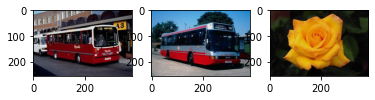

In [6]:
plt.subplot(1,3,1)
plt.imshow(img1)
plt.subplot(1,3,2)
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img3)

Kwantyzacja skalarna. Stosujemy kwantyzację do 4 wartości na każdy z kanałów barwnych. Wybór 4 wartości jest arbitralny. Można testować z innymi wartościami tego parametru. Należy jednak pamiętać, że większe wartości parametru powodują powiększanie wymiaru przestrzeni, w której zdefiniowane są wektory cech oraz wydłużanie obliczeń.

In [7]:
img1q = np.floor(img1/64).astype(int)
img2q = np.floor(img2/64).astype(int)
img3q = np.floor(img3/64).astype(int)

Sprawdzamy, czy faktycznie w obrazie skwantyzowanym pojawiają się wyłącznie 4 wartości.

In [8]:
np.unique(img1q)

array([0, 1, 2, 3])

Spłaszczamy (flatten) obrazy, tak aby łatwiej je przetwarzać.

In [9]:
img1q = img1q.reshape(img1q.shape[0]*img1q.shape[1],3)
img2q = img2q.reshape(img2q.shape[0]*img2q.shape[1],3)
img3q = img3q.reshape(img3q.shape[0]*img3q.shape[1],3)

Konstruujemy wektory cech (histogramy):

In [10]:
hist = {(i,j,k):0 for i in range(0,4) for j in range(0,4) for k in range(0,4)}

In [11]:
wektory_cech = []
for imgX in [img1q, img2q, img3q]:
    h = hist.copy()
    for i in range(0,len(imgX)):
        h[imgX[i][0], imgX[i][1], imgX[i][2]] += 1
    wektory_cech.append(list(h.values()))

Uzyskane histogramy trzech obrazów:

In [12]:
print(wektory_cech[0]), print(wektory_cech[1]), print(wektory_cech[2]);

[37008, 4441, 0, 0, 18, 711, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13012, 1426, 0, 0, 473, 19240, 1045, 0, 0, 28, 427, 0, 0, 0, 0, 0, 2005, 43, 0, 0, 250, 4240, 181, 0, 21, 642, 4648, 526, 0, 0, 43, 476, 0, 1, 0, 0, 18, 44, 15, 0, 501, 214, 620, 43, 0, 12, 248, 5684]
[36228, 3198, 0, 0, 470, 3257, 801, 15, 0, 0, 36, 3076, 0, 0, 0, 0, 1713, 68, 0, 0, 27, 3502, 3539, 0, 0, 8, 1918, 15352, 0, 0, 0, 6, 3215, 177, 0, 0, 53, 969, 568, 0, 0, 62, 15279, 980, 0, 0, 0, 250, 1802, 79, 0, 0, 4, 48, 24, 0, 0, 13, 817, 9, 0, 0, 37, 704]
[57228, 0, 0, 0, 759, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 769, 0, 0, 0, 374, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 6391, 77, 0, 0, 439, 84, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 6479, 38, 0, 0, 24208, 627, 9, 0, 433, 14, 1, 0]


Na tym etapie każdy obraz jest reprezentowany swoim wektorem cech. *Wierzymy*, że jest to wektor adekwatny do treści obrazu. W praktyce stosuje się bardziej wyrafinowane metody reprezentacji treści. 
Wyznaczmy podobieństwo obrazu nr 1 do dwóch pozostałych:

In [13]:
from scipy.spatial.distance import euclidean, cityblock

In [14]:
for i in range(0,3):
    d = euclidean(wektory_cech[0],wektory_cech[i])
    print('Odleglość <obraz_1; obraz_'+str(i+1)+'> = '+str(d))

Odleglość <obraz_1; obraz_1> = 0.0
Odleglość <obraz_1; obraz_2> = 28193.6425457939
Odleglość <obraz_1; obraz_3> = 40868.454240404055


W tym przypadku można wysnuć następujący wniosek: **najbardziej podobnym obrazem do obrazu nr 1 jest obraz nr 2 ze względu na minimalną odległość wektorów cech tych obrazów**.

Wniosek nie zmienia się po zastosowaniu odległości mannhattan:

In [15]:
for i in range(0,3):
    d = cityblock(wektory_cech[0],wektory_cech[i])
    print('Odleglość <obraz_1; obraz_'+str(i+1)+'> = '+str(d))

Odleglość <obraz_1; obraz_1> = 0
Odleglość <obraz_1; obraz_2> = 82350
Odleglość <obraz_1; obraz_3> = 117186


Koniec przykładu

<div class = "alert alert-block alert-warning">
<b> Zadanie (5 punktów) </b> Korzystając z logiki wyżej zbuduj prosty system wyszukiwania obrazów (CBIR),  w którym dla każdego obrazu wzorca zostanie przypisana lista 5 obrazów najbardziej podobnych według przyjętej miary odleglości: Manhattan oraz Euklidesa.    

    
Wykorzystaj podzbiór 100 obrazów z oryginalnego zbioru 1000 obrazów dostępnego pod adresem http://wang.ist.psu.edu/docs/related/. Swój zbiór skonstruuj poprzez wybranie 10 pierwszych obrazów z każdej kategorii tematycznej, tzn. obrazy nr 0..10 (kategoria 1), 100..110 (kategoria 2), 200..210 (kategoria 3), ..., 900..910 (kategoria 10).
    
Wskazówka: po wyznaczeniu wektora cech (histogram) dla każdego obrazu wyznacz kwadratową macierz odległości, gdzie $ij$-ty element takiej macierzy reprezentuje odległość obrazu $i$ do obrazu $j$. Wyszukanie obrazów najbardziej podobnych do obrazu $i$-tego sprowadzać się wówczas będzie do przejrzenia wiersza $i$ takiej macierzy w poszukiwaniu minimalnych elementów macierzowych. Uwaga na elementy diagonalne, które są równe zero (odległość obrazu do samego siebie) - takie elementy nas nie interesują.    
    
Jako wynik (rozwiązanie) zadania przedstaw: pełny kod *.ipynnb realizujący zadanie oraz listy 5 najbardziej podobnych obrazów dla 5 obrazów przykładowych (wklej screenshoty do notebooka lub wynik przedstaw w załączonym dokumencie PDF). Wyniki przedstaw niezależnie dla odległości manhattan oraz euklidesowej.
</div>

*tu umieść swoje rozwiązanie*

In [2]:
import numpy as np
import matplotlib.pyplot as plt



In [3]:
num=[]
for x in range(0,10):
    for y in range(0,10):
        num.append(100*x+y)


In [4]:
for i in num:
    globals()['img%s' % i] = plt.imread('%s.jpg' % i)

In [21]:
for i in num:
    globals()['imgq%s' % i] = globals()['img%s' %i]//64

In [25]:
for i in num:
    globals()['imgq%s' % i] = globals()['imgq%s' %i].reshape(globals()['imgq%s' %i].shape[0]*globals()['imgq%s' %i].shape[1],3)

In [28]:
hist = {(i,j,k):0 for i in range(0,4) for j in range(0,4) for k in range(0,4)}

In [29]:
img_list=[]
for i in num:
    img_list.append(globals()['imgq%s' % i])

In [40]:
wektory_cech = []
for imgX in img_list:
    h = hist.copy()
    for i in range(0,len(imgX)):
        h[imgX[i][0], imgX[i][1], imgX[i][2]] += 1
    wektory_cech.append(list(h.values()))

In [42]:
print(wektory_cech[30]), print(wektory_cech[31]), print(wektory_cech[60]);

[37008, 4441, 0, 0, 18, 711, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13012, 1426, 0, 0, 473, 19240, 1045, 0, 0, 28, 427, 0, 0, 0, 0, 0, 2005, 43, 0, 0, 250, 4240, 181, 0, 21, 642, 4648, 526, 0, 0, 43, 476, 0, 1, 0, 0, 18, 44, 15, 0, 501, 214, 620, 43, 0, 12, 248, 5684]
[36228, 3198, 0, 0, 470, 3257, 801, 15, 0, 0, 36, 3076, 0, 0, 0, 0, 1713, 68, 0, 0, 27, 3502, 3539, 0, 0, 8, 1918, 15352, 0, 0, 0, 6, 3215, 177, 0, 0, 53, 969, 568, 0, 0, 62, 15279, 980, 0, 0, 0, 250, 1802, 79, 0, 0, 4, 48, 24, 0, 0, 13, 817, 9, 0, 0, 37, 704]
[57228, 0, 0, 0, 759, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 769, 0, 0, 0, 374, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 312, 0, 0, 0, 6391, 77, 0, 0, 439, 84, 0, 0, 0, 0, 0, 0, 57, 0, 0, 0, 6479, 38, 0, 0, 24208, 627, 9, 0, 433, 14, 1, 0]


In [43]:
from scipy.spatial.distance import euclidean, cityblock

In [57]:
euclidean_list=[]
for i in range(0,100):
    d = euclidean(wektory_cech[0],wektory_cech[i])
    euclidean_list.append(d)

In [65]:
min_list = sorted(zip(num,euclidean_list), key=lambda t: t[1])[1:6]

In [80]:
min_euclidean_list=[]
for i in range(0,5):
    min_euclidean_list.append(min_list[i][0])

In [81]:
min_euclidean_list

[1, 100, 8, 2, 9]

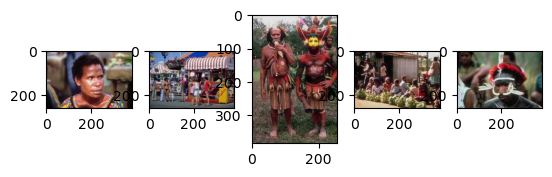

In [88]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [90]:
cityblock_list=[]
for i in range(0,100):
    d = cityblock(wektory_cech[0],wektory_cech[i])
    cityblock_list.append(d)

In [113]:
min_listc = sorted(zip(num,cityblock_list), key=lambda t: t[1])[1:6]

In [114]:
min_cityblock_list=[]
for i in range(0,5):
    min_cityblock_list.append(min_listc[i][0])

In [115]:
min_cityblock_list

[1, 8, 2, 100, 900]

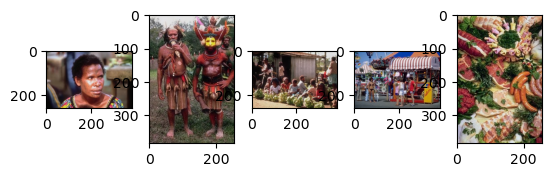

In [117]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [118]:
euclidean_list1=[]
for i in range(0,100):
    d = euclidean(wektory_cech[10],wektory_cech[i])
    euclidean_list1.append(d)

min_list1 = sorted(zip(num,euclidean_list1), key=lambda t: t[1])[1:6]

min_euclidean_list1=[]
for i in range(0,5):
    min_euclidean_list1.append(min_list1[i][0])

In [119]:
min_euclidean_list1

[1, 3, 0, 9, 8]

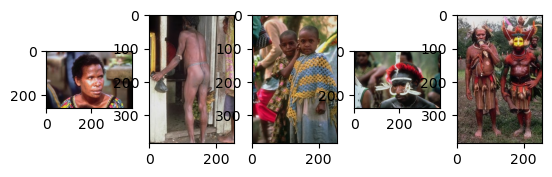

In [109]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list1:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [121]:
cityblock_list1=[]
for i in range(0,100):
    d = cityblock(wektory_cech[10],wektory_cech[i])
    cityblock_list1.append(d)

min_list1c = sorted(zip(num,cityblock_list1), key=lambda t: t[1])[1:6]

min_cityblock_list1=[]
for i in range(0,5):
    min_cityblock_list1.append(min_list1c[i][0])

In [122]:
min_cityblock_list1

[1, 3, 0, 305, 8]

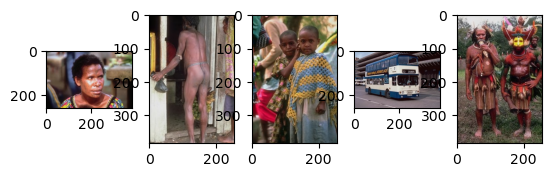

In [124]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list1:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [125]:
euclidean_list2=[]
for i in range(0,100):
    d = euclidean(wektory_cech[20],wektory_cech[i])
    euclidean_list2.append(d)

min_list2 = sorted(zip(num,euclidean_list2), key=lambda t: t[1])[1:6]

min_euclidean_list2=[]
for i in range(0,5):
    min_euclidean_list2.append(min_list2[i][0])

In [126]:
min_euclidean_list2

[9, 0, 305, 1, 206]

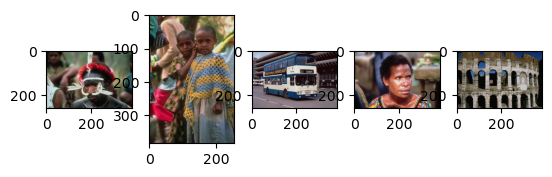

In [128]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list2:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [129]:
cityblock_list2=[]
for i in range(0,100):
    d = cityblock(wektory_cech[20],wektory_cech[i])
    cityblock_list2.append(d)

min_list2c = sorted(zip(num,cityblock_list2), key=lambda t: t[1])[1:6]

min_cityblock_list2=[]
for i in range(0,5):
    min_cityblock_list2.append(min_list2c[i][0])

In [130]:
min_cityblock_list2

[9, 206, 0, 305, 109]

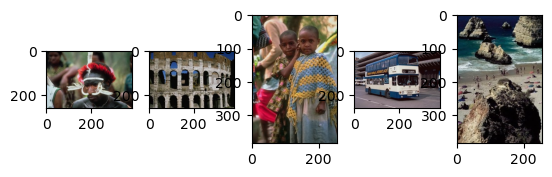

In [131]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list2:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [132]:
euclidean_list3=[]
for i in range(0,100):
    d = euclidean(wektory_cech[30],wektory_cech[i])
    euclidean_list3.append(d)

min_list3 = sorted(zip(num,euclidean_list3), key=lambda t: t[1])[1:6]

min_euclidean_list3=[]
for i in range(0,5):
    min_euclidean_list3.append(min_list3[i][0])

In [133]:
min_euclidean_list3

[302, 303, 6, 9, 7]

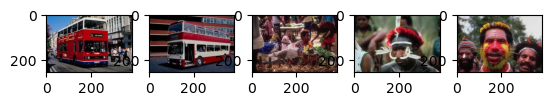

In [134]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list3:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [135]:
cityblock_list3=[]
for i in range(0,100):
    d = cityblock(wektory_cech[30],wektory_cech[i])
    cityblock_list3.append(d)

min_list3c = sorted(zip(num,cityblock_list3), key=lambda t: t[1])[1:6]

min_cityblock_list3=[]
for i in range(0,5):
    min_cityblock_list3.append(min_list3c[i][0])

In [136]:
min_cityblock_list3

[303, 302, 6, 305, 8]

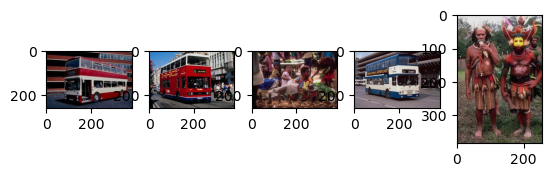

In [137]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list3:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [138]:
euclidean_list4=[]
for i in range(0,100):
    d = euclidean(wektory_cech[40],wektory_cech[i])
    euclidean_list4.append(d)

min_list4 = sorted(zip(num,euclidean_list4), key=lambda t: t[1])[1:6]

min_euclidean_list4=[]
for i in range(0,5):
    min_euclidean_list4.append(min_list4[i][0])

In [139]:
min_euclidean_list4

[407, 409, 404, 401, 403]

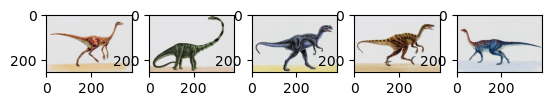

In [140]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list4:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [141]:
cityblock_list4=[]
for i in range(0,100):
    d = cityblock(wektory_cech[40],wektory_cech[i])
    cityblock_list4.append(d)

min_list4c = sorted(zip(num,cityblock_list4), key=lambda t: t[1])[1:6]

min_cityblock_list4=[]
for i in range(0,5):
    min_cityblock_list4.append(min_list4c[i][0])

In [142]:
min_cityblock_list4

[407, 409, 401, 404, 406]

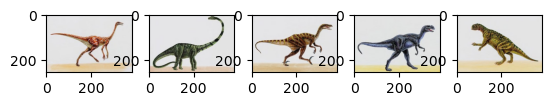

In [143]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list4:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [144]:
euclidean_list5=[]
for i in range(0,100):
    d = euclidean(wektory_cech[50],wektory_cech[i])
    euclidean_list5.append(d)

min_list5 = sorted(zip(num,euclidean_list5), key=lambda t: t[1])[1:6]

min_euclidean_list5=[]
for i in range(0,5):
    min_euclidean_list5.append(min_list5[i][0])

In [145]:
min_euclidean_list5

[507, 502, 501, 108, 708]

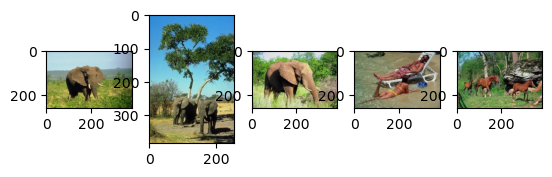

In [148]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list5:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [149]:
cityblock_list5=[]
for i in range(0,100):
    d = cityblock(wektory_cech[50],wektory_cech[i])
    cityblock_list5.append(d)

min_list5c = sorted(zip(num,cityblock_list5), key=lambda t: t[1])[1:6]

min_cityblock_list5=[]
for i in range(0,5):
    min_cityblock_list5.append(min_list5c[i][0])

In [150]:
min_cityblock_list5

[502, 507, 108, 504, 708]

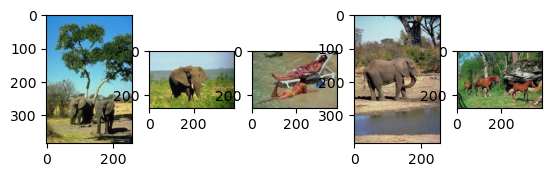

In [151]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list5:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [152]:
euclidean_list6=[]
for i in range(0,100):
    d = euclidean(wektory_cech[60],wektory_cech[i])
    euclidean_list6.append(d)

min_list6 = sorted(zip(num,euclidean_list6), key=lambda t: t[1])[1:6]

min_euclidean_list6=[]
for i in range(0,5):
    min_euclidean_list6.append(min_list6[i][0])

In [153]:
min_euclidean_list6

[609, 606, 604, 709, 605]

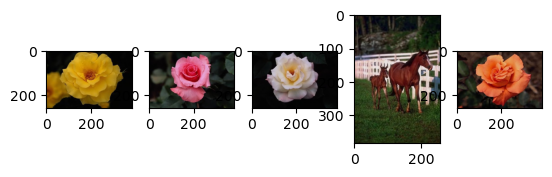

In [154]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list6:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [155]:
cityblock_list6=[]
for i in range(0,100):
    d = cityblock(wektory_cech[60],wektory_cech[i])
    cityblock_list6.append(d)

min_list6c = sorted(zip(num,cityblock_list6), key=lambda t: t[1])[1:6]

min_cityblock_list6=[]
for i in range(0,5):
    min_cityblock_list6.append(min_list6c[i][0])

In [156]:
min_cityblock_list6

[609, 604, 606, 605, 709]

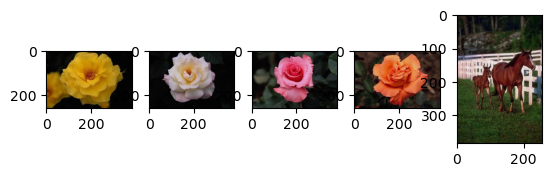

In [157]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list6:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [158]:
euclidean_list7=[]
for i in range(0,100):
    d = euclidean(wektory_cech[70],wektory_cech[i])
    euclidean_list7.append(d)

min_list7 = sorted(zip(num,euclidean_list7), key=lambda t: t[1])[1:6]

min_euclidean_list7=[]
for i in range(0,5):
    min_euclidean_list7.append(min_list7[i][0])

In [159]:
min_euclidean_list7

[601, 509, 705, 706, 701]

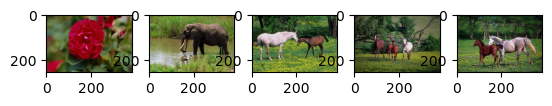

In [160]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list7:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [161]:
cityblock_list7=[]
for i in range(0,100):
    d = cityblock(wektory_cech[70],wektory_cech[i])
    cityblock_list7.append(d)

min_list7c = sorted(zip(num,cityblock_list7), key=lambda t: t[1])[1:6]

min_cityblock_list7=[]
for i in range(0,5):
    min_cityblock_list7.append(min_list7c[i][0])

In [162]:
min_cityblock_list7

[601, 706, 705, 701, 509]

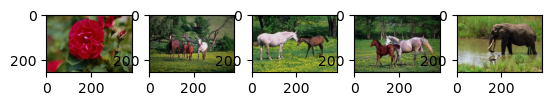

In [163]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list7:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [164]:
euclidean_list8=[]
for i in range(0,100):
    d = euclidean(wektory_cech[80],wektory_cech[i])
    euclidean_list8.append(d)

min_list8 = sorted(zip(num,euclidean_list8), key=lambda t: t[1])[1:6]

min_euclidean_list8=[]
for i in range(0,5):
    min_euclidean_list8.append(min_list8[i][0])

In [165]:
min_euclidean_list8

[309, 308, 107, 306, 100]

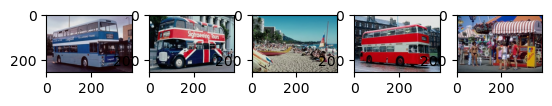

In [166]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list8:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [167]:
cityblock_list8=[]
for i in range(0,100):
    d = cityblock(wektory_cech[80],wektory_cech[i])
    cityblock_list8.append(d)

min_list8c = sorted(zip(num,cityblock_list8), key=lambda t: t[1])[1:6]

min_cityblock_list8=[]
for i in range(0,5):
    min_cityblock_list8.append(min_list8c[i][0])

In [168]:
min_cityblock_list8

[309, 308, 107, 801, 306]

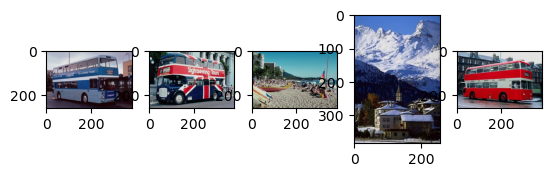

In [169]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list8:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [170]:
euclidean_list9=[]
for i in range(0,100):
    d = euclidean(wektory_cech[90],wektory_cech[i])
    euclidean_list9.append(d)

min_list9 = sorted(zip(num,euclidean_list9), key=lambda t: t[1])[1:6]

min_euclidean_list9=[]
for i in range(0,5):
    min_euclidean_list9.append(min_list9[i][0])

In [171]:
min_euclidean_list9

[2, 1, 906, 907, 905]

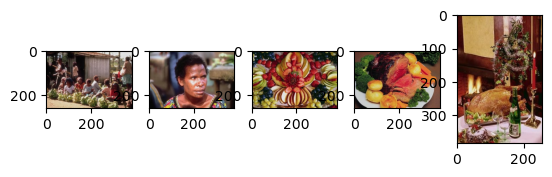

In [172]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_euclidean_list9:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1

In [173]:
cityblock_list9=[]
for i in range(0,100):
    d = cityblock(wektory_cech[90],wektory_cech[i])
    cityblock_list9.append(d)

min_list9c = sorted(zip(num,cityblock_list9), key=lambda t: t[1])[1:6]

min_cityblock_list9=[]
for i in range(0,5):
    min_cityblock_list9.append(min_list9c[i][0])

In [174]:
min_cityblock_list9

[2, 905, 1, 0, 5]

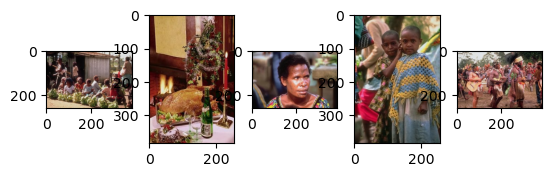

In [175]:
f, axarr = plt.subplots(1,5) 
j=0
for i in min_cityblock_list9:
    axarr[j].imshow(globals()['img%s' % i])
    j+=1